#### Chargement

In [89]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer


from joblib import dump, load
import cloudpickle
import pickle

import time

In [90]:
df=pd.read_csv("weatherAUS.csv",parse_dates =True) 

df.head(2) #dec 2008 à Juin 2017 Rainfall, Evaporationphoto à 9am et 3pm (vent (vitesse et direction), nuage, humidité,temperature et pression)
# Conversion de la date au format Datetime
display(df.head(2)) #dec 2008 à Juin 2017 #photo à 9am et 3pm (vent (vitesse et direction), nuage, humidité,temperature et pression)
df.shape
display(df.info())

# Chemin du dossier d'enregistrement
base_path = "Dataset_preprocesse/"

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

None

In [91]:
#Conserver les noms des colonnes, et des stations présents initialement
nom_colonne_initial = df.columns
nom_station_initial = list(set(df["Location"]))

### Preprocessing de l'EDA

In [92]:
# 1. Suppression des stations avec >25% de manquant 
### En entrainement : Supprimait Penrith, SalmonsGums, MountGini, Newcastle // Suppression manuelle en plus de ['Williamtown', 'Melbourne'] chez ABO

# Nombre total de cellules par Location
total_cells_per_location = df.groupby("Location").size() * (df.shape[1] - 1)  # -1 pour exclure la colonne Location elle-même
# Nombre total de NaN par Location (toutes colonnes sauf 'Location')
nan_counts_per_location = df.drop(columns="Location").isna().groupby(df["Location"]).sum().sum(axis=1)
# Ratio NaN global par Location
nan_ratio = nan_counts_per_location / total_cells_per_location
# Locations valides (moins de 25% de NaN global)
valid_locations = nan_ratio[nan_ratio <= 0.25].index
# Filtrage du DataFrame
df = df[df["Location"].isin(valid_locations)]

##### Ajout d'infos

In [93]:
# Convertir la date au format Datetime, et var continu, et ajout de colonnes année, mois et jour de la semaine
df["Date"]=pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df["Month"] = df['Date'].dt.month
df["Year"] = df['Date'].dt.year
df["Saison"] = df["Month"].apply( lambda x : "Eté" if x in [12, 1, 2] else "Automne" if x in [3, 4, 5] else "Hiver" if x in [6, 7, 8] else "Printemps")

In [94]:
# Latitude, Longitude
with open("dico scaler/dico_station_geo.pkl", "rb") as fichier:
    dico_charge = pickle.load(fichier)
print(dico_charge)  # Vérification du contenu

df_dico_station_geo = pd.DataFrame.from_dict(dico_charge, orient="index",columns=["Lat", "Lon"])
df_dico_station_geo.columns = ["Latitude", "Longitude"]
df = df.merge(right=df_dico_station_geo, left_on="Location", right_index=True, how="left")

{'Albury': (-36.0737734, 146.9135265), 'BadgerysCreek': (-33.8831452, 150.742466), 'Cobar': (-31.96666285, 145.30450537474044), 'CoffsHarbour': (-30.2985996, 153.1094116), 'Moree': (-29.4617202, 149.8407153), 'Newcastle': (-32.9192953, 151.7795348), 'NorahHead': (-33.2816667, 151.5677778), 'NorfolkIsland': (-29.0328038, 167.9483137), 'Penrith': (-33.7511954, 150.6941711), 'Richmond': (-37.80745, 144.99072125408728), 'Sydney': (-33.8698439, 151.2082848), 'SydneyAirport': (-33.9498935, 151.18196819346016), 'WaggaWagga': (-35.115, 147.3677778), 'Williamtown': (-32.815, 151.8427778), 'Wollongong': (-34.4243941, 150.89385), 'Canberra': (-35.2975906, 149.1012676), 'Tuggeranong': (-35.4209771, 149.0921341), 'MountGinini': (-35.5297437, 148.7725396), 'Ballarat': (-37.5623013, 143.8605645), 'Bendigo': (-36.7590183, 144.2826718), 'Sale': (-38.1094463, 147.0656717), 'MelbourneAirport': (-37.6667554, 144.8288501411705), 'Melbourne': (-37.8142454, 144.9631732), 'Mildura': (-34.195274, 142.1503146),

In [95]:
# Dictionnaire climat
climat_mapping = {
    "Cairns": "Tropical",
    "Townsville": "Tropical",
    "Darwin": "Tropical",
    "Broome": "Tropical",
    "AliceSprings": "Désert",
    "CooberPedy": "Désert",
    "Oodnadatta": "Désert",
    "Kalgoorlie": "Désert",
    "Esperance": "Aride",
    "Perth": "Tempéré",
    "Albany": "Tempéré",
    "Adelaide": "Tempéré",
    "Hobart": "Tempéré",
    "Melbourne": "Tempéré",
    "Canberra": "Tempéré",
    "Sydney": "Subtropical",
    "Newcastle": "Subtropical",
    "Wollongong": "Subtropical",
    "Brisbane": "Subtropical",
    "Launceston": "Tempéré",
    "Ballarat": "Tempéré",
    "Rockhampton": "Subtropical",
    "Mildura": "Aride",
    "Cobar": "Désert",
    "MountGambier": "Tempéré",
    "NorfolkIsland": "Subtropical",
    "WaggaWagga": "Tempéré",
    "WeeWaa": "Aride",
    "Moree": "Aride",
    "Charleville": "Aride",
    "TennantCreek": "Désert",
    "Katherine": "Tropical",
    "Giles": "Désert",
    "Portland": "Tempéré",
    "Albury": "Tempéré",
    "BadgerysCreek": "Subtropical",
    "CoffsHarbour": "Subtropical",
    "NorahHead": "Subtropical",
    "Penrith": "Subtropical",
    "Richmond": "Subtropical",
    "SydneyAirport": "Subtropical",
    "Williamtown": "Subtropical",
    "Tuggeranong": "Tempéré",
    "MountGinini": "Tempéré",
    "Bendigo": "Tempéré",
    "Sale": "Tempéré",
    "MelbourneAirport": "Tempéré",
    "Nhil": "Aride",
    "Watsonia": "Tempéré",
    "Dartmoor": "Tempéré",
    "GoldCoast": "Subtropical",
    "Nuriootpa": "Tempéré",
    "Woomera": "Désert",
    "Witchcliffe": "Tempéré",
    "PearceRAAF": "Tempéré",
    "PerthAirport": "Tempéré",
    "SalmonGums": "Aride",
    "Walpole": "Tempéré",
    "Uluru": "Désert",

}

# Ajout de la colonne climate au dataframe
df['Climat'] = df["Location"].map(climat_mapping)
distrib_climat = df["Climat"].value_counts(normalize=True)*100

print(distrib_climat)


Climat
Tempéré        52.934206
Subtropical    25.254798
Tropical        8.137782
Désert          7.976541
Aride           5.696672
Name: proportion, dtype: float64


##### Traitement

In [96]:
# 2. Suppression des features 
df = df.drop(["Sunshine","Evaporation"], axis = 1)

In [97]:
# 3. Traitement de la variable cible : Suppression des NaN et Label Encoder de cette variable indicatrice en variable binaire
df = df.dropna(subset=["RainTomorrow"], axis=0, how="any")

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["RainTomorrow"] = encoder.fit_transform(df["RainTomorrow"])  #N=0, Y=1

In [98]:
# 4. Suppression des enregistrements quand Year < 2009
# df = df[df["Year"] >= 2009]

### Preprocessing après import fichier Florent

RAF EDA Florent : Faire plus tot suppression de 25%, ajout jour +dico station pour mes visuels , puis les supprimer à la fin de l'EDA. Attention la modif de % va modifier le nb de lignes du fichier de sortie actuelle de Florent. Je te laisse relancer ta pipeline après mes modifs? (Je peux les faire Lundi)
Florent : A mettre après son EDA : suppression enregistrement <2009, suppression NaN de Rain Today

##### Suppressions de stations non qualitatives

In [99]:
#Récap des suppressions (avant complétion des NaN et normalisation)
nom_colonne_actuel = df.columns
print("Colonnes ajoutées :",[col for col in nom_colonne_actuel if col not in nom_colonne_initial])
print("Colonnes enlevées :",[col for col in nom_colonne_initial if col not in nom_colonne_actuel])


nom_station_actuel = list(set(df["Location"]))
print("Stations enlevées :",[station for station in nom_station_initial if station not in nom_station_actuel])

Colonnes ajoutées : ['Month', 'Year', 'Saison', 'Latitude', 'Longitude', 'Climat']
Colonnes enlevées : ['Evaporation', 'Sunshine']
Stations enlevées : ['Penrith', 'MountGinini', 'SalmonGums', 'Newcastle']


#Suppressions des stations avec beaucoup de NAN, ou des mois de relevés avec beaucoup de NaN

# 4 stations qui ne remontent ni les pressions : ni la nébulosité ("MountGinini","Penrith","SalmonGums") ou ni les rafales ("Newcastle")
station_a_supprimer = ["MountGinini","Penrith","SalmonGums", "Newcastle","Melbourne"]
df = df.loc[~df["Location"].isin(station_a_supprimer)] 

# mois où les démarrages des relevés sont de mauvaises qualité (3 premiers mois de Dartmoor, les premiers jours de Wollongong)
to_remove_bad_launch = [
    (1, 2009, "Dartmoor"),
    (2, 2009, "Dartmoor"),
    (3, 2009, "Dartmoor"),
    (12, 2008, "Wollongong")] 
df = df[~df.set_index(["Month", "Year", "Location"]).index.isin(to_remove_bad_launch)]

#Période pendant laquelle la qualité des relevés diminuent subitement
remove_periods = [
    # Albany : 2015-08 à 2017-06
    {"start": pd.Timestamp('2015-08-01'), "end": pd.Timestamp('2017-06-30'), "station": "Albany"},
    # Coffs Harbour : 2014-05 à 2015-02
    {"start": pd.Timestamp('2014-05-01'), "end": pd.Timestamp('2015-02-28'), "station": "CoffsHarbour"},
    # Canberra : 08-2009 à 02-2010
    {"start": pd.Timestamp('2009-08-01'), "end": pd.Timestamp('2010-02-28'), "station": "Canberra"}]

# Filtrer et supprimer les lignes dont les dates tombent dans ces périodes
for period in remove_periods:
    mask = (df['Location'] == period['station']) & (df['Date'] >= period['start']) & (df['Date'] <= period['end'])
    df = df[~mask]

df = df.reset_index()
df = df.drop("index", axis = 1)

# Suppression de la station Williamtown, qui a des NaN le WE et potentiellement des reports de mesures qui se cumulent les jours suivants les NAN
df = df.loc[df["Location"]!="Williamtown"]


#### Suppression features inutiles qui proviennent de l'EDA

In [100]:
# Suppressions des features inutiles 
df = df.drop(["RainToday","Saison","Climat"], axis = 1)

# RainToday est calculé sur Rainfall et entraînera une colinéarité. De plus, elle a été construite a posteriori,
# donc elle ne peut pas être utilisée comme variable explicative dans le modèle prédictif. 

#### Complétions autorisées des NAN

In [101]:
print("Nb NaN",df.isna().sum().sum())
print("soit",round(df.isna().sum().sum()/(df.shape[0]*df.shape[1]),4)*100,"% du dataset")
display(pd.DataFrame(df.isna().sum(), columns=["Nombre de NA"]))

Nb NaN 128462
soit 4.1000000000000005 % du dataset


,Nombre de NA
Date,0
Location,0
MinTemp,277
MaxTemp,144
Rainfall,1222
WindGustDir,6130
WindGustSpeed,6070
WindDir9am,7865
WindDir3pm,2255
WindSpeed9am,924


Colonnes non prises Index([], dtype='object')


<Axes: >

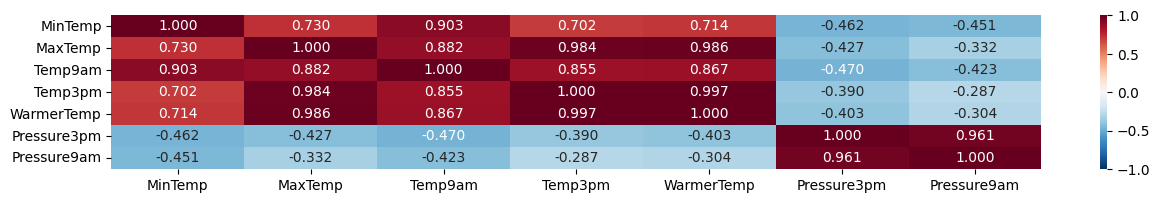

In [102]:
# Corrélations (coef de Pearson) par Heatmap
# Créations de colonnes temporaire pour aider à la complétion
df["WarmerTemp"] = df[["Temp9am", "Temp3pm"]].max(axis=1)

#Corrélation : 
dataframe_correlation = df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WarmerTemp',"Pressure3pm","Pressure9am"]]
print("Colonnes non prises",dataframe_correlation.select_dtypes(exclude = ['int', 'float']).columns)
dataframe_correlation=dataframe_correlation.select_dtypes(include = ['int', 'float'])


#Corrélation de Pearson entre les variables explicatives quantitatives présentées sous forme de Heatmap
plt.figure(figsize=(15, 2))  # Optional: Adjust figure size
sns.heatmap(dataframe_correlation.corr(),annot=True,cmap="RdBu_r",fmt= ".3f", center = 0, vmin=-1, vmax=1) 

In [103]:
#Traiter les NAN de MaxTemp, Temp3pm, Pressure9am, Pressure3pm où corrélation >0.96
df["MaxTemp"]=df["MaxTemp"].fillna(df["WarmerTemp"].round(0)) #arrondi à l'entier comme la definition du BOM
df = df.drop(["WarmerTemp"],axis=1)

df["Temp3pm"]=df["Temp3pm"].fillna(df["MaxTemp"]) #Si on prenait WarmerTemp, il serait composé uniquement de Temp9am en l'absence de Temp3pm. Or le taux de corrélation de Temp9am est moins intéressant que MaxTemp

#0.964# montrer nb de NaN avant et après
df["Pressure3pm"]=df["Pressure3pm"].fillna(df["Pressure9am"])
df["Pressure9am"]=df["Pressure9am"].fillna(df["Pressure3pm"])

#### Encodage Stateless (sans risque de fuite de données)

In [104]:
#Encodage cyclique du mois 
def encode_month(df, month_col="Month"):
    """Encode le mois en sin et cos puis supprime la colonne originale."""
    df['month_sin'] = np.sin(2 * np.pi * (df[month_col] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df[month_col] - 1) / 12)
    df=df.drop(columns=[month_col],axis=1)
    return df

df = encode_month(df, "Month")

In [ ]:
# Encodage cyclique de la direction du vent (et du cas "pas de vent")
# 1) Définir la liste des 16 directions cycliques (rose des vents)
# ------------------------------------------------------------------------
#    Ici, on ordonne explicitement les directions dans le sens horaire,
#    en commençant par "N" à l’indice 0, puis "NNE", "NE", etc.
directions = [
    "N",   "NNE", "NE",  "ENE",
    "E",   "ESE", "SE",  "SSE",
    "S",   "SSW", "SW",  "WSW",
    "W",   "WNW", "NW",  "NNW"
]

# ------------------------------------------------------------------------
# 2) Construire le mapping direction → angle (en radians)
# ------------------------------------------------------------------------
#    Chaque direction est associée à un angle = idx * (2π / 16),
#    où idx est l’indice de la direction dans la liste ci-dessus.
#    Ex. : "N" → 0 rad, "ENE" → 3 * (2π/16) = 3π/8, etc.
angle_mapping = {
    dir_name: (idx * 2 * np.pi / 16)
    for idx, dir_name in enumerate(directions)
}

# ------------------------------------------------------------------------
# 3) Parcourir chaque couple (colonne de direction, colonne de vitesse)
#    - Pour WindDir9am et WindDir3pm, on gère le cas “pas de vent”.
#    - Pour WindGustDir, la vitesse est toujours > 0 (pas de “pas de vent”).
#    On crée pour chaque couple :
#      • des colonnes sin/cos de l’angle (avec NaN si direction absente),
#      • éventuellement un indicateur NoWind_<col_speed> pour WindDir9am/3pm.
# ------------------------------------------------------------------------
for (col_dir, col_speed) in [
    ("WindDir9am",  "WindSpeed9am"),
    ("WindDir3pm",  "WindSpeed3pm"),
    ("WindGustDir", "WindGustSpeed")
]:
    # ------------------------------------------------------------
    # Détection du cas “pas de vent” ET direction absente/blanche
    # ------------------------------------------------------------
    handle_no_wind = col_dir in ["WindDir9am", "WindDir3pm"]
    if handle_no_wind:
        # a) Détecter les lignes où la vitesse vaut exactement 0
        is_exact_zero = (df[col_speed] == 0)
        # b) Détecter si la direction est manquante : NaN ou chaîne vide
        mask_dir_missing = df[col_dir].isna() | (df[col_dir].astype(str).str.strip() == "")
        # c) Combinaison : “pas de vent” ET direction absente
        mask_no_wind = is_exact_zero & mask_dir_missing
        # d) Créer l’indicateur NoWind_<col_speed> (1 si vitesse == 0)
        #    On met 1 si vitesse = 0, même si direction présente ou non.
        df[f"NoWind_{col_speed}"] = is_exact_zero.astype(int)
    else:
        # Pour WindGust, pas de “pas de vent” → on n’utilise pas NoWind
        is_exact_zero = pd.Series(False, index=df.index)
        mask_no_wind = pd.Series(False, index=df.index)

    # ------------------------------------------------------------
    # Mapper la direction textuelle → angle (NaN si direction absente ou non reconnue)
    # ------------------------------------------------------------
    df[f"{col_dir}_angle"] = df[col_dir].map(angle_mapping)

    # ------------------------------------------------------------
    # Si “pas de vent” ET direction absente, forcer angle = 0 rad
    # ------------------------------------------------------------
    if handle_no_wind:
        df.loc[mask_no_wind, f"{col_dir}_angle"] = 0.0

    # ------------------------------------------------------------
    # Calculer sin(angle) et cos(angle)
    #   • Si angle est NaN (direction absente pour d’autres raisons), sin/cos restent NaN.
    #   • Si “pas de vent”, angle forcé à 0 → sin=0, cos=1.
    #   • Sinon, angle valide → sin(angle), cos(angle).
    # ------------------------------------------------------------
    sin_col = f"{col_dir}_sin"
    cos_col = f"{col_dir}_cos"
    df[sin_col] = np.nan
    df[cos_col] = np.nan

    # a) Cas “pas de vent” (force angle=0) → sin=0, cos=1
    if handle_no_wind:
        df.loc[mask_no_wind, sin_col] = 0.0
        df.loc[mask_no_wind, cos_col] = 1.0

    # b) Cas angle valide pour toutes les lignes
    mask_angle_valid = df[f"{col_dir}_angle"].notna()
    df.loc[mask_angle_valid, sin_col] = np.sin(df.loc[mask_angle_valid, f"{col_dir}_angle"])
    df.loc[mask_angle_valid, cos_col] = np.cos(df.loc[mask_angle_valid, f"{col_dir}_angle"])

    # ------------------------------------------------------------
    # Nettoyage final : supprimer les colonnes de direction textuelle et d’angle
    # ------------------------------------------------------------
    df.drop(columns=[col_dir, f"{col_dir}_angle"], inplace=True)

# ------------------------------------------------------------------------
# À l’issue de cette boucle :
# → Pour WindDir9am et WindDir3pm :
#     • Une colonne NoWind_<col_speed> (1 si vitesse == 0, 0 sinon).
#     • Deux colonnes <col_dir>_sin et <col_dir>_cos :
#         - Si “pas de vent” & direction absente → (0, 1).
#         - Si vent présent & angle valide → (sin(angle), cos(angle)).
#         - Si vent présent mais angle manquant → (NaN, NaN).
#
# → Pour WindGustDir :
#     • Pas de colonne NoWind (jamais de “pas de vent”).
#     • Deux colonnes WindGustDir_sin et WindGustDir_cos :
#         - Si direction valide → (sin(angle), cos(angle)).
#         - Sinon (colonne direction initiale absente/mal encodée) → (NaN, NaN).
# ------------------------------------------------------------------------

#### Split du modèle

In [107]:
# 3 Split du model

#Création d'un df de features et un de target (ici label = classe)
features_data = df.drop(columns = ["RainTomorrow"])
target = df["RainTomorrow"]

#création de 2 jeux de données : un d'entrainement et un de test
X_train, X_test, y_train, y_test = train_test_split(features_data, target, random_state = 80, stratify = target, test_size = 0.2)

### Suite du preprocessing

#### FONCTIONS

In [108]:
class CloudKNNImputer(BaseEstimator, TransformerMixin):
    """
    Impute les colonnes 'Cloud9am' et 'Cloud3pm' via KNN en utilisant des variables explicatives,
    avec standardisation et réinversion, en respectant les bornes [0, 8] (échelle octa).
    
    Params :
        variables_knn : variables utilisées pour l’imputation (doit inclure Cloud9am, Cloud3pm)
        n_neighbors : nombre de voisins KNN
    """
    def __init__(self, variables_knn=None, n_neighbors=4):
        self.variables_knn = variables_knn
        self.n_neighbors = n_neighbors
        self.scaler_ = None
        self.knn_ = None
        self.columns_to_impute_ = ["Cloud9am", "Cloud3pm"]

    def fit(self, X, y=None):
        df = X.copy()
        df_knn = df[self.variables_knn].copy()

        self.scaler_ = StandardScaler()
        df_scaled = pd.DataFrame(self.scaler_.fit_transform(df_knn), columns=self.variables_knn, index=df.index)
        self.knn_ = KNNImputer(n_neighbors=self.n_neighbors)
        self.knn_.fit(df_scaled)
        return self

    def transform(self, X, y=None):
        df = X.copy()
        df_knn = df[self.variables_knn].copy()
        val_nan = df_knn[self.columns_to_impute_].isna()

        df_scaled = pd.DataFrame(self.scaler_.transform(df_knn), columns=self.variables_knn, index=df.index)
        df_imputed = pd.DataFrame(self.knn_.transform(df_scaled), columns=self.variables_knn, index=df.index)
        # Annulation de la standardisation
        df_imputed = pd.DataFrame(self.scaler_.inverse_transform(df_imputed), columns=self.variables_knn, index=df.index) #pour

        # Arrondir à l’échelle octa (0 à 8) # arrondi + borné
        for col in self.columns_to_impute_:
            vals = df_imputed[col].round().clip(0, 8)
            df.loc[val_nan[col], col] = vals[val_nan[col]]

        return df


In [109]:
def visualisation(df_before, df, feat1, feat2):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        sns.histplot(df_before[feat1].dropna(), bins=10, kde=True, ax=axes[0, 0], color="tomato", label="Avant", alpha=0.6, stat="percent")
        sns.histplot(df[feat1], bins=10, kde=True, ax=axes[0, 0], color="steelblue", label="Après", alpha=0.6, stat="percent")
        axes[0, 0].set_title(("Histogramme {0}").format(feat1))
        axes[0, 0].legend()

        sns.histplot(df_before[feat2].dropna(), bins=10, kde=True, ax=axes[0, 1], color="tomato", label="Avant", alpha=0.6, stat="percent")
        sns.histplot(df[feat2], bins=10, kde=True, ax=axes[0, 1], color="steelblue", label="Après", alpha=0.6, stat="percent")
        axes[0, 1].set_title(("Histogramme {0}").format(feat2))
        axes[0, 1].legend()

        sns.boxplot(data=pd.DataFrame({"Avant": df_before[feat1], "Après": df[feat1]}), ax=axes[1, 0])
        axes[1, 0].set_title(("Boxplot {0}").format(feat1))

        sns.boxplot(data=pd.DataFrame({"Avant": df_before[feat2], "Après": df[feat2]}), ax=axes[1, 1])
        axes[1, 1].set_title(("Boxplot {0}").format(feat2))

        plt.tight_layout()
        plt.show()

In [110]:
class KNNImputerTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer pour réaliser une imputation par KNN avec pondération sur certaines colonnes,
    standardisation préalable et réintégration de colonnes exclues.

    Le processus est le suivant :
      1. Suppression des colonnes non à imputer (par exemple, 'Date', 'Location', 'RainTomorrow').
      2. Application d’un facteur de pondération sur certaines colonnes (ici 'month_sin', 'month_cos', 'Lat', 'Lon').
      3. Standardisation des données.
      4. Imputation des valeurs manquantes avec KNNImputer.
      5. Annulation de la standardisation.
      6. Suppression des colonnes pondérées et réintégration des colonnes exclues initialement.

    Les paramètres ajustables sont :
      - excluded_columns : liste des colonnes à ne pas imputer.
      - weight_columns : dictionnaire des colonnes pour lesquelles appliquer un facteur multiplicateur.
      - n_neighbors : nombre de voisins pour KNNImputer.
    """
    def __init__(self,
                 excluded_columns=['Date', 'Location'],
                 weight_columns={'month_sin': 20, 'month_cos': 20, 'Latitude': 10, 'Longitude': 10},
                 n_neighbors=3):
        self.excluded_columns = excluded_columns
        self.weight_columns = weight_columns
        self.n_neighbors = n_neighbors
        # Add an attribute to store the feature names seen during fit
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Store the feature names observed during fit
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        self.feature_names_in_ = X.columns.tolist()

        # Create the DataFrame for imputation:
        # Remove excluded columns
        df_impute = X.drop(columns=self.excluded_columns).copy()
        # Also keep weighted columns (for reintegration after imputation)
        self.weighted_columns_ = list(self.weight_columns.keys())
        # Apply weights to specific columns
        for col, factor in self.weight_columns.items():
            if col in df_impute.columns: # Add a check if the weighted column exists
                 df_impute[col] = df_impute[col] * factor
            # else: # Optional: Handle case where weighted column is not in df_impute
            #      print(f"Warning: Weighted column '{col}' not found in data to impute.")


        # Standardization of data
        self.scaler_ = StandardScaler()
        df_impute_scaled = pd.DataFrame(self.scaler_.fit_transform(df_impute),
                                        columns=df_impute.columns, index=df_impute.index)

        # Imputation by KNN
        self.imputer_ = KNNImputer(n_neighbors=self.n_neighbors, weights='distance')
        self.imputer_.fit(df_impute_scaled)
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
             raise TypeError("Input X must be a pandas DataFrame.")

        # --- Add this section to handle potential column mismatch/reordering ---
        # Ensure the incoming DataFrame has the expected columns from fit
        if self.feature_names_in_ is None:
            raise RuntimeError("Transformer has not been fitted yet.")

        # Check for missing required columns
        missing_cols = set(self.feature_names_in_) - set(X.columns)
        if missing_cols:
            raise ValueError(f"Input DataFrame is missing columns observed during fit: {missing_cols}")

        # Reindex the incoming DataFrame to match the column order from fit
        # This is crucial to avoid the ValueError from scikit-learn components
        X_reindexed = X[self.feature_names_in_].copy()
        # --- End of added section ---


        # Separation of columns to impute and columns to reintegrate
        # Use the reindexed DataFrame
        df_impute = X_reindexed.drop(columns=self.excluded_columns).copy()
        # Keep both excluded and weighted columns from the reindexed DataFrame
        df_ajout = X_reindexed[self.excluded_columns + self.weighted_columns_].copy()

        # Application of weights to specific columns
        for col, factor in self.weight_columns.items():
             if col in df_impute.columns: # Add a check if the weighted column exists
                 df_impute[col] = df_impute[col] * factor
            # else: # Optional: Handle case where weighted column is not in df_impute
            #      print(f"Warning: Weighted column '{col}' not found in data to impute.")


        # Standardization with the already fitted scaler
        df_impute_scaled = pd.DataFrame(self.scaler_.transform(df_impute),
                                        columns=df_impute.columns, index=df_impute.index)

        # Imputation on transformed data
        df_imputed_values = self.imputer_.transform(df_impute_scaled)

        # Inverse standardization to return to original scales
        df_imputed = pd.DataFrame(self.scaler_.inverse_transform(df_imputed_values),
                                  columns=df_impute.columns, index=df_impute.index)

        # Removal of weighted columns (as they were used only for imputation)
        df_imputed.drop(columns=self.weighted_columns_, inplace=True)

        # Reintegration of excluded columns
        # Use the original index from X_reindexed to merge correctly
        df_imputed = df_imputed.merge(right=df_ajout, left_index=True, right_index=True)

        return df_imputed

In [111]:
## FONCTIONS pour le scaling

def add_engineered_features(X: pd.DataFrame,
                            ref_year: int = 2007, #ref_year = 1e année du dataset d'entrainement est 0
                            lat0: float = -25.0,
                            lon0: float = 133.0) -> pd.DataFrame:
    X_fe = X.copy()
    # Deltas temporel 
    X_fe['Year_delta']      = X_fe['Year']      - ref_year
    # Deltas géographiques
    # Transformer Latitude et Longitude en Latitude_delta et Longitude_delta : où le centre du dataset d'entrainement est 0, et correspond au centre de l'Australie.    
    # A noter : un degré de longitude à l'équateur = 110km, et à 60°Sud = 60 km . Pour corriger, on peut faire un Haversine et encodage azimut.
    X_fe['Latitude_delta']  = X_fe['Latitude']  - lat0
    X_fe['Longitude_delta'] = X_fe['Longitude'] - lon0
    # Log-transform
    X_fe['Rainfall']    = np.log1p(X_fe['Rainfall'])
    X_fe = X_fe.drop(['Year','Latitude','Longitude'], axis=1)
    return X_fe


def fit_and_save_scalers(X_train_fe: pd.DataFrame,
                         export_path: str = "dico scaler/scalers.joblib") -> dict:
    scalers = {}
    for key, cols in feature_lists.items():
        if key == 'std':
            scaler = StandardScaler()
        elif key == 'minmax':
            scaler = MinMaxScaler()
        elif key == 'robust':
            scaler = RobustScaler()
        scaler.fit(X_train_fe[cols])
        scalers[key] = scaler
    dump({'scalers': scalers, 'feature_lists': feature_lists},
         export_path)
    return scalers


# Fonction pour charger et appliquer les scalers sur n’importe quel X
def load_and_apply_scalers(X_fe: pd.DataFrame,
                           import_path: str = "dico scaler/scalers.joblib"
                          ) -> pd.DataFrame:
    artefact = load(import_path)
    scalers = artefact['scalers']
    feature_lists = artefact['feature_lists']
    X_scaled = X_fe.copy()
    for key, cols in feature_lists.items():
        X_scaled[cols] = scalers[key].transform(X_scaled[cols])
    return X_scaled

#### Traitrement des NAN

In [112]:
# Traitement des manquants dans Cloud9am et Cloud3pm

# Chemin du dossier d'enregistrement
base_path_scaler = "dico scaler/"

# Encodage des nuages
variables_knn = [
    "Cloud9am", "Cloud3pm", "Humidity9am", "Humidity3pm",
    "Rainfall", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm",
    "WindSpeed9am", "WindSpeed3pm", "Latitude", "Longitude"
]


cloud_imputer = CloudKNNImputer(variables_knn=variables_knn, n_neighbors=4)

# Entraînement
X_train_before = X_train.copy() #Sauvegarde pour vérification graphique
X_train = cloud_imputer.fit_transform(X_train)

# Sauvegarde
with open(base_path_scaler+"cloud_imputer.pkl", "wb") as f:
    cloudpickle.dump(cloud_imputer, f)


# Application sur test 
X_test_before = X_test.copy() 
X_test = cloud_imputer.transform(X_test)


In [113]:
# Traitement des autres manquants avec la class dédiée
transformer = KNNImputerTransformer()

X_train = transformer.fit_transform(X_train)

# Sauvegarde
with open("dico scaler/transformer_KNNImputerABO.pkl", "wb") as f:
    cloudpickle.dump(transformer, f)

X_test = transformer.transform(X_test)

In [114]:
# visualisation(X_train_before, X_train, "Cloud9am", "Cloud3pm")
# visualisation(X_test_before, X_test, "Cloud9am", "Cloud3pm")

In [115]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

0
0


#### Traitement des colinéarités

In [116]:
# Il y a un risque de colinéarité entre Temp9am, Temp3pm, MinTemp, MaxTemp. Nous allons supprimer les features de Min/Max pour créer amplitude thermique journalière.
def amplitude_thermique(X) :
    X["Amplitude_Temp"] = X['MaxTemp']- X['MinTemp']
    X = X.drop(["MinTemp", "MaxTemp"], axis=1)
    return X 

X_train = amplitude_thermique(X_train)
X_test = amplitude_thermique(X_test)

#### Suppression des features intuiles


In [117]:
X_train = X_train.drop(["Date","Location"],axis=1)
X_test = X_test.drop(["Date","Location"],axis=1)

#### Sauvegarde avant scaling

In [118]:
X_train.to_csv(base_path + 'X_train_to_be_scaled.csv', index=True)
X_test.to_csv(base_path + 'X_test_to_be_scaled.csv', index=True)

In [ ]:
# Nous allons ajouter des features d’ingénierie géographiques et temporelles :
# - Deltas temporels (Year_delta) basés sur l’année de référence de début de dataset (2007).
# - Deltas géographiques (Latitude_delta, Longitude_delta) basés sur le centre géogrpahique de l’Australie (lat0=-25.0, lon0=133.0).


#### Scaling

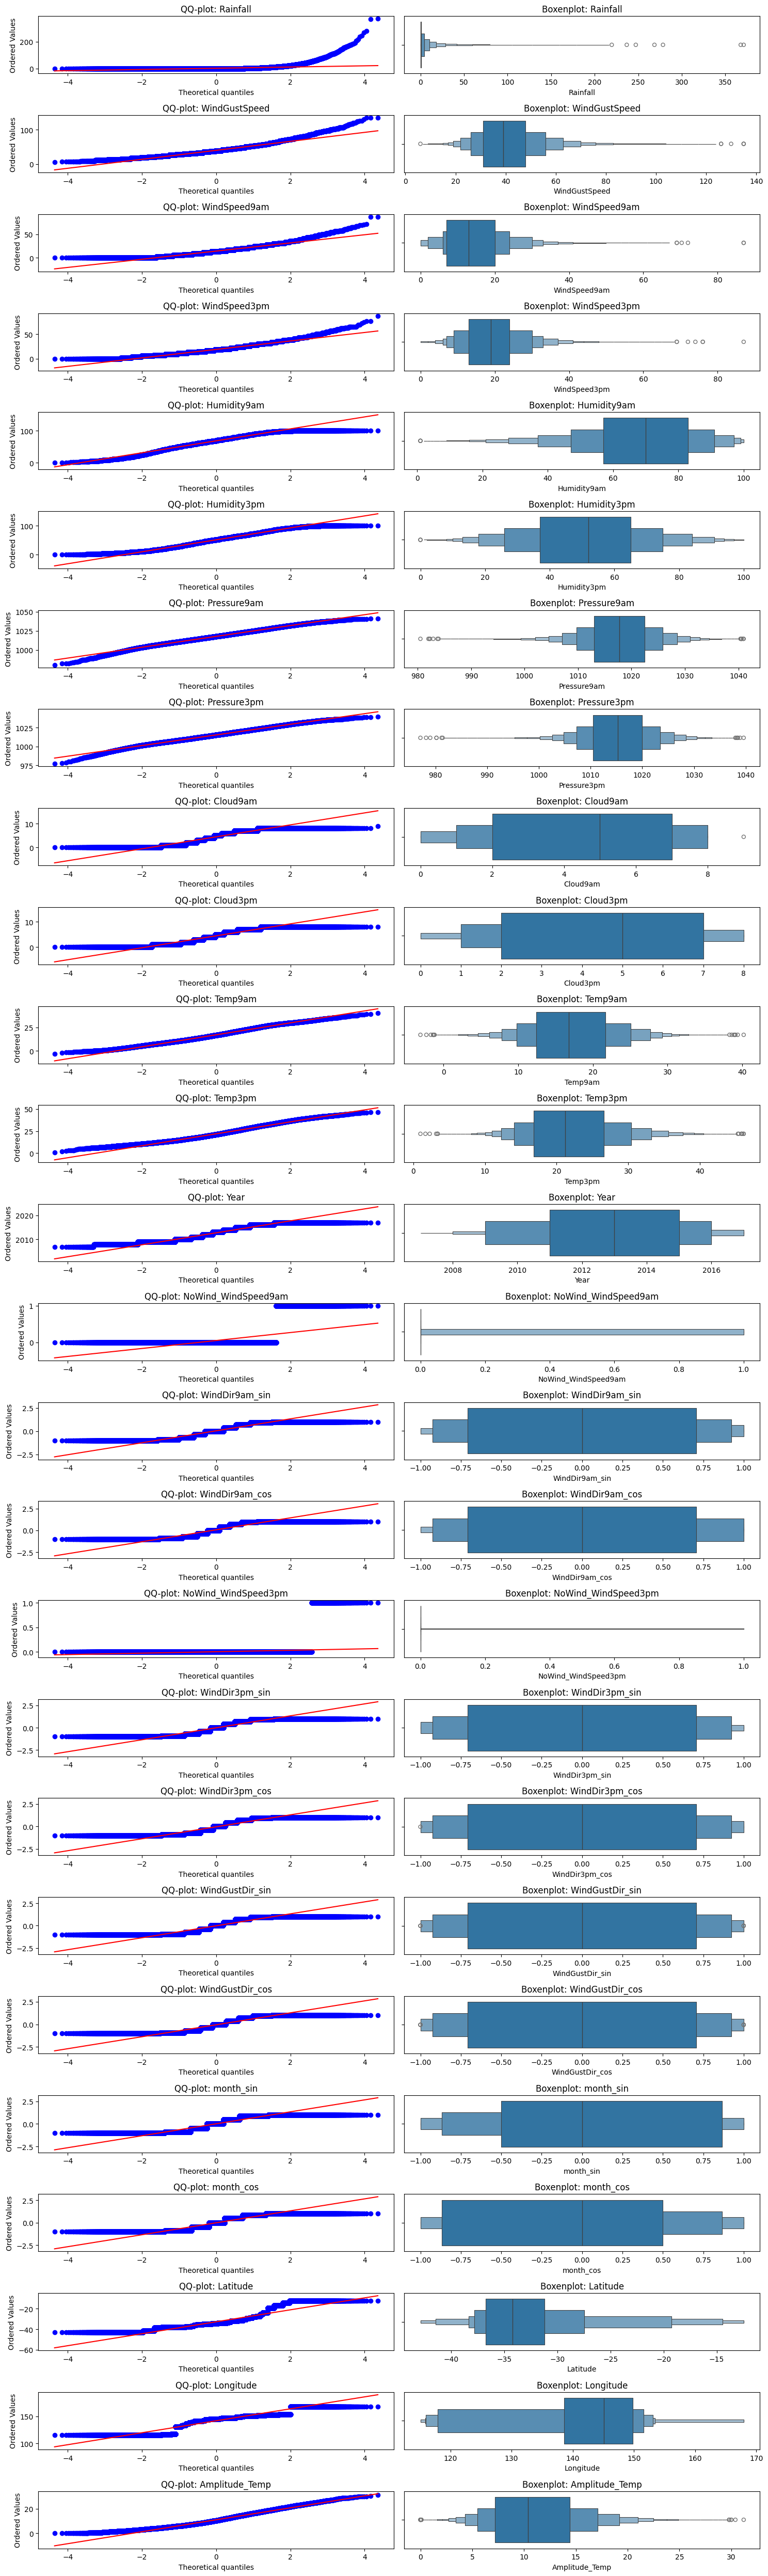

In [119]:
def choix_scaling(df):
    # Création de la figure avec 2 colonnes et autant de lignes que de colonnes dans df
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=2, figsize=(15, 50))

    # Parcours de chaque colonne
    for i, col in enumerate(df.columns):
        # Sélectionner l'axe pour le QQ-plot
        plt.sca(axes[i, 0])    
        # QQ-plot (à gauche)
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        axes[i, 0].set_title(f'QQ-plot: {col}')

        # Boxenplot (à droite)
        sns.boxenplot(x=df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxenplot: {col}')

    plt.tight_layout()
    plt.show()
choix_scaling(X_train)

StandardScaling : Distribution "presque" normale + quelques valeurs extrêmes pour Temp(Min/Max/9am/3pm) et Pressure(9am/3pm)

MinMaxScaling : Distribution PAS normale + très peu outliers : (mais utile pour des descentes de gradient (=reseau de neurone) car a besoin d'intervalle [0;1])
> Dans un intervalle de 0 à 100% 'Humidity9am', 'Humidity3pm'

RobustScaling : Quand il y a beaucoup d'outliers : 
WindSpeed(9am/3pm/Gust) n'a pas une distribution normale et a des valeurs extrêmes
Même chose pour Rainfall (qui pourrait avoir besoin d'un traitement supplémentaire au vue de sa distribution)

Scaling des variables quantitative
#pas utile pour les modèles arbres

In [120]:
# 1) Listes de Features
scaling_std = ["Amplitude_Temp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm"]
scaling_min_max = ["Humidity9am", "Humidity3pm"]
scaling_robust = ["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Rainfall", "Longitude_delta", "Latitude_delta"]
# Year est transformé en delta Year, où 2007 est l'année 0. Le modème gerera mieux les nouvelles données
# Latitude et Longitude sont transformés en Latitude_delta et Longitude_delta, où le centre du dataset d'entrainement est 0, et correspond au centre de l'Australie.
# Latitude_delta et Longitude_delta sont transformés avec RobustScaler, car ils sont très asymétriques (surréprésentation des stations au sud de l'Australie, et à l'est de l'Australie).

feature_lists = {
    'std':     scaling_std,
    'minmax':  scaling_min_max,
    'robust':  scaling_robust
}

# Application des fonctions
X_train_fe = add_engineered_features(X_train, ref_year=2007)
scalers = fit_and_save_scalers(X_train_fe, export_path="dico scaler/scalers.joblib")
X_train = load_and_apply_scalers(X_train_fe, import_path="dico scaler/scalers.joblib")

X_test_fe = add_engineered_features(X_test, ref_year=2007)
X_test  = load_and_apply_scalers(X_test_fe,  import_path="dico scaler/scalers.joblib")

### Sauvegarde 

In [121]:
display(X_train.head(2))
display(X_test.head(2))
display(y_test.head(2))
display(y_train.head(2))

#Récap des modifications de features 
nom_colonne_actuel = X_train.columns
print("Colonnes ajoutées :",[col for col in nom_colonne_actuel if col not in nom_colonne_initial])
print("Colonnes enlevées :",[col for col in nom_colonne_initial if col not in nom_colonne_actuel])

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,WindDir3pm_sin,WindDir3pm_cos,WindGustDir_sin,WindGustDir_cos,month_sin,month_cos,Amplitude_Temp,Year_delta,Latitude_delta,Longitude_delta
62102,1.625609,0.117647,0.461538,0.454545,0.878788,0.79,-1.367708,-1.509215,7.0,7.0,...,-0.92388,-0.382683,-1.000000,-1.734723e-16,-0.5,-8.660254e-01,-0.284668,4.0,-0.704101,0.176313
109242,0.000000,0.644605,-0.307692,1.090909,0.696970,0.69,0.410279,0.542058,6.0,5.0,...,-0.92388,-0.382683,-0.719821,-2.720399e-01,-1.0,-1.836970e-16,-0.630165,3.0,-0.149216,-2.419775


,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,WindDir3pm_sin,WindDir3pm_cos,WindGustDir_sin,WindGustDir_cos,month_sin,month_cos,Amplitude_Temp,Year_delta,Latitude_delta,Longitude_delta
2584,0.000000,-0.647059,-0.846154,-0.909091,0.747475,0.31,0.071615,0.043485,1.0,2.0,...,-0.382683,0.923880,0.707107,0.707107,0.866025,0.500000,1.300554,9.0,-0.337914,0.162777
33673,3.620755,-0.647059,-0.307692,0.090909,0.949495,0.87,1.144052,0.955162,8.0,8.0,...,0.923880,0.382683,0.923880,0.382683,0.500000,-0.866025,-1.382129,2.0,0.044140,0.542506


2584     0
33673    1
Name: RainTomorrow, dtype: int64

62102     1
109242    1
Name: RainTomorrow, dtype: int64

Colonnes ajoutées : ['NoWind_WindSpeed9am', 'WindDir9am_sin', 'WindDir9am_cos', 'NoWind_WindSpeed3pm', 'WindDir3pm_sin', 'WindDir3pm_cos', 'WindGustDir_sin', 'WindGustDir_cos', 'month_sin', 'month_cos', 'Amplitude_Temp', 'Year_delta', 'Latitude_delta', 'Longitude_delta']
Colonnes enlevées : ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [122]:
#Export features
X_train.to_csv(base_path + 'X_train_scaled.csv', index=True)
X_test.to_csv(base_path + 'X_test_scaled.csv', index=True)

# Export label
y_train.to_csv(base_path + 'y_train.csv', index=True)
y_test.to_csv(base_path + 'y_test.csv', index=True)